# Autoenkoder liniowy, konwolucyjny i cnn

Pobieramy biblioteki:

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

funkcje do pobierania i ładowania datasetu:

In [30]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalizacja do zakresu [-1, 1]
    ])
    
    # Pobierz cały zbiór MNIST
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    return train_dataset, test_dataset

def prepare_datasets(train_dataset, test_dataset, normal_class):
    # Zbiór treningowy - tylko normalna klasa
    train_indices = [i for i, (_, label) in enumerate(train_dataset) if label == normal_class]
    train_normal = Subset(train_dataset, train_indices)
    
    # Zbiór testowy - wszystkie cyfry
    test_normal_indices = [i for i, (_, label) in enumerate(test_dataset) if label == normal_class]
    test_anomaly_indices = [i for i, (_, label) in enumerate(test_dataset) if label != normal_class]
    
    test_normal = Subset(test_dataset, test_normal_indices)
    test_anomaly = Subset(test_dataset, test_anomaly_indices)
    
    print(f"\nRozmiar zbioru treningowego (klasa {normal_class}): {len(train_normal)}")
    print(f"Rozmiar zbioru testowego (klasa {normal_class}): {len(test_normal)}")
    print(f"Rozmiar zbioru testowego (anomalie): {len(test_anomaly)}")
    
    return train_normal, test_normal, test_anomaly

### Autoenkoder Liniowy:
Na początku enkoder spłasza zdjęcie 28x28 pikseli do wektora mającego 784 elemntów po czym redukuje wymiary tego wektora do 64 a następnie decoder z tego skompresowanego wektora rekonstruuje obraz do początkowych rozmiarów. 

In [31]:
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super(LinearAutoencoder, self).__init__()
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2)
        )
        # Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()  # Sigmoid dla lepszej rekonstrukcji
        )
    
    def forward(self, x):
        # Normalizacja wejścia z [-1, 1] do [0, 1]
        x_normalized = (x + 1) / 2
        encoded = self.encoder(x_normalized)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 1, 28, 28)
        # Powrót do zakresu [-1, 1]
        decoded = decoded * 2 - 1
        return decoded


### Autoenkoder konwolucyjny:
Tutaj już nie spłaszczamy bo konwolucje pozwalają na operowaniu na macierzach, najpierw redukujemy wymiar obrazu z 28x28 do 7x7 a następnie w dekoderze przy pomocy upsamplingu wracamy do oryginalnych rozmiarów, wykorzystując patterny poznane przez konwolucje.

In [54]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Dropout2d(0.4),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
            nn.Dropout2d(0.3),  # Zredukowany dropout dla lepszej rekonstrukcji
            
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, padding=1),  # 7x7 -> 4x4
            nn.Dropout2d(0.3),
            
            nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1),  # 4x4x4 = 64 (kompromis!)
            nn.BatchNorm2d(4),
            nn.ReLU()
        )
        # Decoder 
        self.decoder = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1),  # Dopasowane do 4 kanałów
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),  # 4x4 -> 8x8
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),  # 8x8 -> 16x16
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Upsample(size=28, mode='nearest'),  # 16x16 -> 28x28
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        # Normalizacja wejścia z [-1, 1] do [0, 1]
        x_normalized = (x + 1) / 2
        encoded = self.encoder(x_normalized)
        decoded = self.decoder(encoded)
        # Powrót do zakresu [-1, 1]
        decoded = decoded * 2 - 1
        return decoded

### Konwolucyjna sieć neuronowa:
Będzie wykorzystywana do klasyfikacji obrazów

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

### Ustawiamy parametry:

In [34]:
# Ustawienia
NORMAL_CLASS = 0  # Cyfra normalna
EPOCHS = 30  
BATCH_SIZE = 128
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


### Funkcje do trenowania modeli
Naszą funkcją straty będzie $||x-x'||^2$
 tak jak jest napisane w dokumencie, a optymalizatorem standardowo ADAM

In [35]:
# Funkcja do trenowania autoenkoderów
def train_autoencoder(model, train_loader, epochs, lr, model_name):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f"\n{'='*50}")
    print(f"Trenowanie: {model_name}")
    print(f"{'='*50}")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(DEVICE)
            
            optimizer.zero_grad()
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    
    return model


W przypadku CNN dodajemy labele, 1 dla wybranej cyfry i 0 dla anomalii

In [36]:
# Funkcja do trenowania CNN
def train_cnn(model, train_normal, test_normal_loader, test_anomaly_loader, epochs, lr):
    """Trenuj CNN - z przykładami obu klas (normal=1, anomaly=0)"""
    model = model.to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f"\n{'='*50}")
    print(f"Trenowanie: CNN")
    print(f"{'='*50}")
    
    # dane treningowe: normalne (klasa 1) + próbki anomalii (klasa 0) aby zachować równowagę pomiędzy klasami
    from torch.utils.data import ConcatDataset   
    test_dataset = test_anomaly_loader.dataset
    anomaly_train_size = len(train_normal) // 2  
    anomaly_train_indices = torch.randperm(len(test_dataset))[:anomaly_train_size].tolist()
    anomaly_train = Subset(test_dataset.dataset if hasattr(test_dataset, 'dataset') else test_dataset, 
                           [test_dataset.indices[i] if hasattr(test_dataset, 'indices') else i 
                            for i in anomaly_train_indices])
    
    # łączymy dane normalne i anomalie
    combined_dataset = ConcatDataset([train_normal, anomaly_train])
    train_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    print(f"Dane treningowe: {len(train_normal)} normalnych + {len(anomaly_train)} anomalii")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for data, label in train_loader:
            data = data.to(DEVICE)
            # Label: 1 dla normalnych (NORMAL_CLASS), 0 dla anomalii
            labels = (label == NORMAL_CLASS).float().unsqueeze(1).to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        if (epoch + 1) % 5 == 0:
            # Ewaluacja
            model.eval()
            correct_normal = 0
            total_normal = 0
            correct_anomaly = 0
            total_anomaly = 0
            
            with torch.no_grad():
                for data, _ in test_normal_loader:
                    data = data.to(DEVICE)
                    outputs = model(data)
                    predicted = (outputs > 0.5).float()
                    total_normal += data.size(0)
                    correct_normal += (predicted == 1).sum().item()
                
                for data, _ in test_anomaly_loader:
                    data = data.to(DEVICE)
                    outputs = model(data)
                    predicted = (outputs > 0.5).float()
                    total_anomaly += data.size(0)
                    correct_anomaly += (predicted == 0).sum().item()
            
            acc_normal = 100 * correct_normal / total_normal
            acc_anomaly = 100 * correct_anomaly / total_anomaly
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}, "
                  f"Acc Normal: {acc_normal:.2f}%, Acc Anomaly: {acc_anomaly:.2f}%")
    
    return model

Funkcje do mierzenia metryk/ obliczenia błędu rekonstrukcji:

In [37]:
def calculate_reconstruction_error(model, data_loader):
    """Oblicz błąd rekonstrukcji"""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(DEVICE)
            reconstructed = model(data)
            error = torch.mean((data - reconstructed) ** 2, dim=[1, 2, 3])
            errors.extend(error.cpu().numpy())
    
    return np.array(errors)

In [38]:
def calculate_cnn_scores(model, data_loader):
    """Oblicz wyniki CNN (prawdopodobieństwo przynależności do klasy normalnej)"""
    model.eval()
    scores = []
    
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(DEVICE)
            outputs = model(data)
            scores.extend(outputs.cpu().numpy().flatten())
    
    return np.array(scores)

In [39]:
def determine_threshold(normal_errors, percentile=95):
    """Wyznacz próg anomalii, my wykorzystujemy 95 percentyl"""
    threshold = np.percentile(normal_errors, percentile)
    return threshold

In [40]:
def evaluate_model(normal_errors, anomaly_errors, threshold, model_name):
    """Ewaluacja autoenkoderów"""
    print(f"\n{'='*50}")
    print(f"Wyniki: {model_name}")
    print(f"{'='*50}")
    
    # Statystyki błędów
    print(f"Błąd rekonstrukcji - Normalne:")
    print(f"  Średnia: {np.mean(normal_errors):.6f}")
    print(f"  Mediana: {np.median(normal_errors):.6f}")
    print(f"  Std: {np.std(normal_errors):.6f}")
    
    print(f"\nBłąd rekonstrukcji - Anomalie:")
    print(f"  Średnia: {np.mean(anomaly_errors):.6f}")
    print(f"  Mediana: {np.median(anomaly_errors):.6f}")
    print(f"  Std: {np.std(anomaly_errors):.6f}")
    
    print(f"\nPróg anomalii: {threshold:.6f}")
    
    # Detekcja anomalii
    normal_correct = np.sum(normal_errors <= threshold)
    normal_total = len(normal_errors)
    anomaly_correct = np.sum(anomaly_errors > threshold)
    anomaly_total = len(anomaly_errors)
    
    accuracy = 100 * (normal_correct + anomaly_correct) / (normal_total + anomaly_total)
    
    print(f"\nDetekcja:")
    print(f"  Poprawnie sklasyfikowane normalne: {normal_correct}/{normal_total} ({100*normal_correct/normal_total:.2f}%)")
    print(f"  Poprawnie sklasyfikowane anomalie: {anomaly_correct}/{anomaly_total} ({100*anomaly_correct/anomaly_total:.2f}%)")
    print(f"  Dokładność ogólna: {accuracy:.2f}%")
    
    # ROC AUC
    y_true = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomaly_errors))])
    y_scores = np.concatenate([normal_errors, anomaly_errors])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    return roc_auc, fpr, tpr, accuracy

In [41]:
def evaluate_cnn(normal_scores, anomaly_scores, model_name):
    """Ewaluacja CNN (wyższe wartości = normalne, niższe = anomalie)"""
    print(f"\n{'='*50}")
    print(f"Wyniki: {model_name}")
    print(f"{'='*50}")
    
    # Statystyki
    print(f"Wyniki - Normalne:")
    print(f"  Średnia: {np.mean(normal_scores):.6f}")
    print(f"  Mediana: {np.median(normal_scores):.6f}")
    print(f"  Std: {np.std(normal_scores):.6f}")
    
    print(f"\nWyniki - Anomalie:")
    print(f"  Średnia: {np.mean(anomaly_scores):.6f}")
    print(f"  Mediana: {np.median(anomaly_scores):.6f}")
    print(f"  Std: {np.std(anomaly_scores):.6f}")
    
    # Próg 
    threshold = 0.5
    print(f"\nPróg: {threshold:.6f}")
    
    # Detekcja
    normal_correct = np.sum(normal_scores >= threshold)
    normal_total = len(normal_scores)
    anomaly_correct = np.sum(anomaly_scores < threshold)
    anomaly_total = len(anomaly_scores)
    
    accuracy = 100 * (normal_correct + anomaly_correct) / (normal_total + anomaly_total)
    
    print(f"\nDetekcja:")
    print(f"  Poprawnie sklasyfikowane normalne: {normal_correct}/{normal_total} ({100*normal_correct/normal_total:.2f}%)")
    print(f"  Poprawnie sklasyfikowane anomalie: {anomaly_correct}/{anomaly_total} ({100*anomaly_correct/anomaly_total:.2f}%)")
    print(f"  Dokładność ogólna: {accuracy:.2f}%")
    
    # ROC AUC (odwracamy scores bo CNN daje wyższe wartości dla normalnych)
    y_true = np.concatenate([np.zeros(len(normal_scores)), np.ones(len(anomaly_scores))])
    y_scores = np.concatenate([1 - normal_scores, 1 - anomaly_scores])
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    return roc_auc, fpr, tpr, accuracy

In [42]:
def visualize_reconstructions(model, test_loader, n_samples=5, model_name="Model"):
    """Wizualizacja przykładowych rekonstrukcji"""
    model.eval()
    
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images[:n_samples].to(DEVICE)
    
    with torch.no_grad():
        reconstructed = model(images)
    
    images = images.cpu()
    reconstructed = reconstructed.cpu()
    
    # Denormalizacja dla wizualizacji (z [-1, 1] do [0, 1])
    images = images * 0.5 + 0.5
    reconstructed = reconstructed * 0.5 + 0.5
    
    fig, axes = plt.subplots(2, n_samples, figsize=(12, 4))
    fig.suptitle(f'{model_name} - Oryginał vs Rekonstrukcja')
    
    for i in range(n_samples):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Oryginał')
        
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Rekonstrukcja')
    
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_")}_reconstructions.png')

In [61]:
def plot_error_distribution(normal_errors, anomaly_errors, threshold, model_name):
    """Wizualizacja rozkładu błędów rekonstrukcji z histogramem i box plotem"""
    fig = plt.figure(figsize=(15, 6))
    
    bins = np.linspace(0, max(np.max(normal_errors), np.max(anomaly_errors)), 50)
    plt.hist(normal_errors, bins=bins, alpha=0.6, label='Normalne', color='green', density=True)
    plt.hist(anomaly_errors, bins=bins, alpha=0.6, label='Anomalie', color='red', density=True)
    plt.axvline(threshold, color='blue', linestyle='--', linewidth=2, label=f'Próg: {threshold:.4f}')
    plt.xlabel('Błąd rekonstrukcji (MSE)', fontsize=11)
    plt.ylabel('Gęstość', fontsize=11)
    plt.title(f'{model_name}\nRozkład błędu rekonstrukcji', fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    filename = f'{model_name.replace(" ", "_")}_error_distribution.png'
    plt.savefig(filename, dpi=150)
    plt.show()
    plt.close()



In [67]:
def plot_roc_curves(results):
    """Narysuj krzywe ROC dla wszystkich modeli"""
    plt.figure(figsize=(10, 8))
    
    for model_name, (roc_auc, fpr, tpr, _) in results.items():
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Krzywe ROC - Porównanie modeli')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curves_comparison.png')
    plt.show()

In [68]:
def plot_accuracy_comparison(results):
    """Narysuj wykres słupkowy porównujący accuracy wszystkich modeli"""
    plt.figure(figsize=(10, 6))
    
    model_names = list(results.keys())
    accuracies = [results[name][3] for name in model_names]
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    bars = plt.bar(model_names, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    plt.xlabel('Model', fontsize=12, fontweight='bold')
    plt.title('Porównanie dokładności modeli detekcji anomalii', fontsize=14, fontweight='bold')
    plt.ylim([0, 105])
    plt.grid(True, alpha=0.3, axis='y', linestyle='--')
    plt.tight_layout()
    plt.savefig('accuracy_comparison.png', dpi=300)
    plt.show()


## Trenowanie modeli:
Skoro mamy już wszystkie niezbędne funkcje, możemy przejść do trenowania modeli

In [46]:
print(f"Klasa normalna: {NORMAL_CLASS}")

# 1. Wczytaj dane
train_dataset, test_dataset = load_data()

# 2. Przygotuj zbiory
train_normal, test_normal, test_anomaly = prepare_datasets(train_dataset, test_dataset, NORMAL_CLASS)
train_loader = DataLoader(train_normal, batch_size=BATCH_SIZE, shuffle=True)
test_normal_loader = DataLoader(test_normal, batch_size=BATCH_SIZE, shuffle=False)
test_anomaly_loader = DataLoader(test_anomaly, batch_size=BATCH_SIZE, shuffle=False)

results = {}

Klasa normalna: 0

Rozmiar zbioru treningowego (klasa 0): 5923
Rozmiar zbioru testowego (klasa 0): 980
Rozmiar zbioru testowego (anomalie): 9020



Trenowanie: Autoenkoder Liniowy
Epoch [5/30], Loss: 0.136997
Epoch [10/30], Loss: 0.097250
Epoch [15/30], Loss: 0.079218
Epoch [20/30], Loss: 0.055399
Epoch [25/30], Loss: 0.044601
Epoch [30/30], Loss: 0.040089

Wyniki: Autoenkoder Liniowy
Błąd rekonstrukcji - Normalne:
  Średnia: 0.042931
  Mediana: 0.037158
  Std: 0.023657

Błąd rekonstrukcji - Anomalie:
  Średnia: 0.182133
  Mediana: 0.176625
  Std: 0.046002

Próg anomalii: 0.087218

Detekcja:
  Poprawnie sklasyfikowane normalne: 931/980 (95.00%)
  Poprawnie sklasyfikowane anomalie: 8953/9020 (99.26%)
  Dokładność ogólna: 98.84%
  ROC AUC: 0.9956


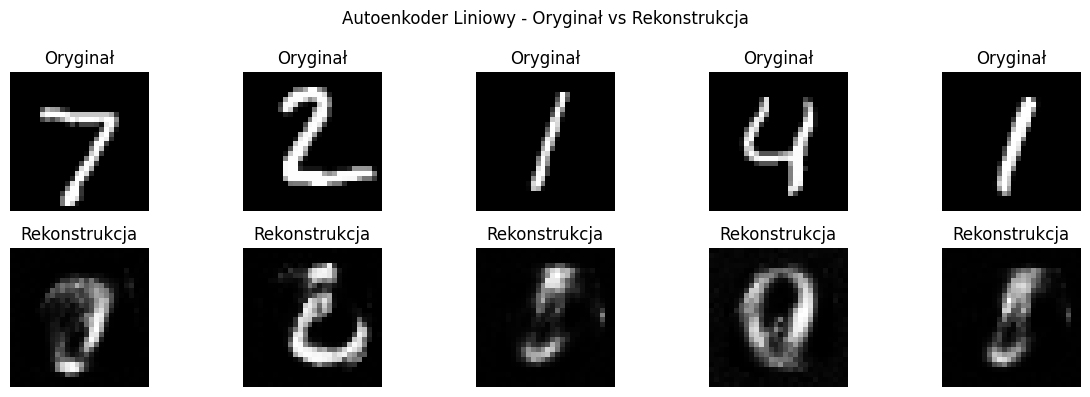

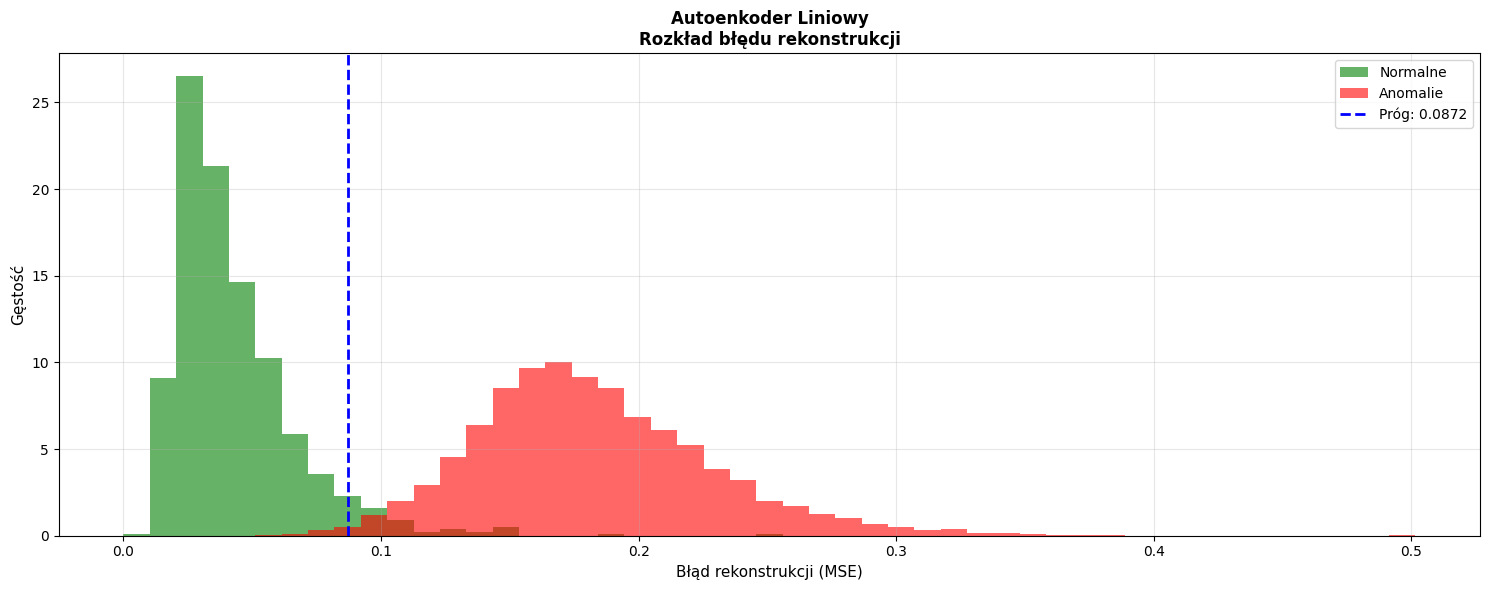

In [62]:
#  AUTOENKODER LINIOWY
linear_ae = LinearAutoencoder()
linear_ae = train_autoencoder(linear_ae, train_loader, EPOCHS, LEARNING_RATE, "Autoenkoder Liniowy")

# Obliczamy błędy rekonstrukcji
normal_errors_linear = calculate_reconstruction_error(linear_ae, test_normal_loader)
anomaly_errors_linear = calculate_reconstruction_error(linear_ae, test_anomaly_loader)

# Wyznacz próg
threshold_linear = determine_threshold(normal_errors_linear, percentile=95)

# Ewaluacja
roc_auc, fpr, tpr, accuracy = evaluate_model(normal_errors_linear, anomaly_errors_linear, 
                                    threshold_linear, "Autoenkoder Liniowy")
results["Autoenkoder Liniowy"] = (roc_auc, fpr, tpr, accuracy)

# Wizualizacje
visualize_reconstructions(linear_ae, test_anomaly_loader, n_samples=5, 
                        model_name="Autoenkoder Liniowy")
plot_error_distribution(normal_errors_linear, anomaly_errors_linear, 
                        threshold_linear, "Autoenkoder Liniowy")

Przez to, że kompresja autoenkodera liniowego nie jest w stanie zapisywać nie wiadomo ile patternów, dobrze radzi sobie z rozpoznawaniem cyfry normalnej od anomalii, co pokazuje chociażby accuracy, natomiast rekonstrukcja anomalii jest już mocno zniekształcona i model tworzy zakrzywienia wynikające że normalna liczba w naszym przypadku to 0. Dla cyfr takich jak 2 model coś tam nawet tworzy, bo cyfra ta ma zakrzywienia ale dla takiej czwórki nie poradził sobie kompletnie


Trenowanie: Autoenkoder Konwolucyjny
Epoch [5/30], Loss: 0.070185
Epoch [10/30], Loss: 0.058057
Epoch [15/30], Loss: 0.053524
Epoch [20/30], Loss: 0.051014
Epoch [25/30], Loss: 0.048711
Epoch [30/30], Loss: 0.047375

Wyniki: Autoenkoder Konwolucyjny
Błąd rekonstrukcji - Normalne:
  Średnia: 0.038740
  Mediana: 0.033225
  Std: 0.020352

Błąd rekonstrukcji - Anomalie:
  Średnia: 0.177832
  Mediana: 0.169700
  Std: 0.062573

Próg anomalii: 0.056461

Detekcja:
  Poprawnie sklasyfikowane normalne: 852/980 (86.94%)
  Poprawnie sklasyfikowane anomalie: 8998/9020 (99.76%)
  Dokładność ogólna: 98.50%
  ROC AUC: 0.9934


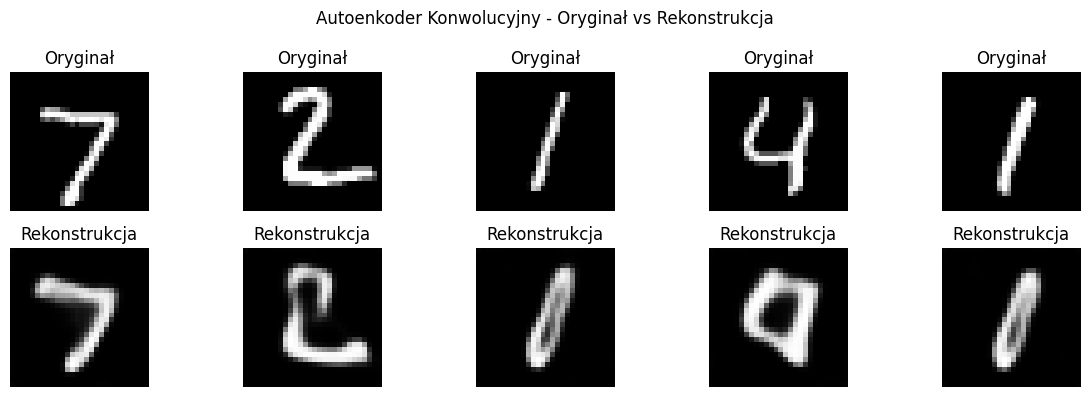

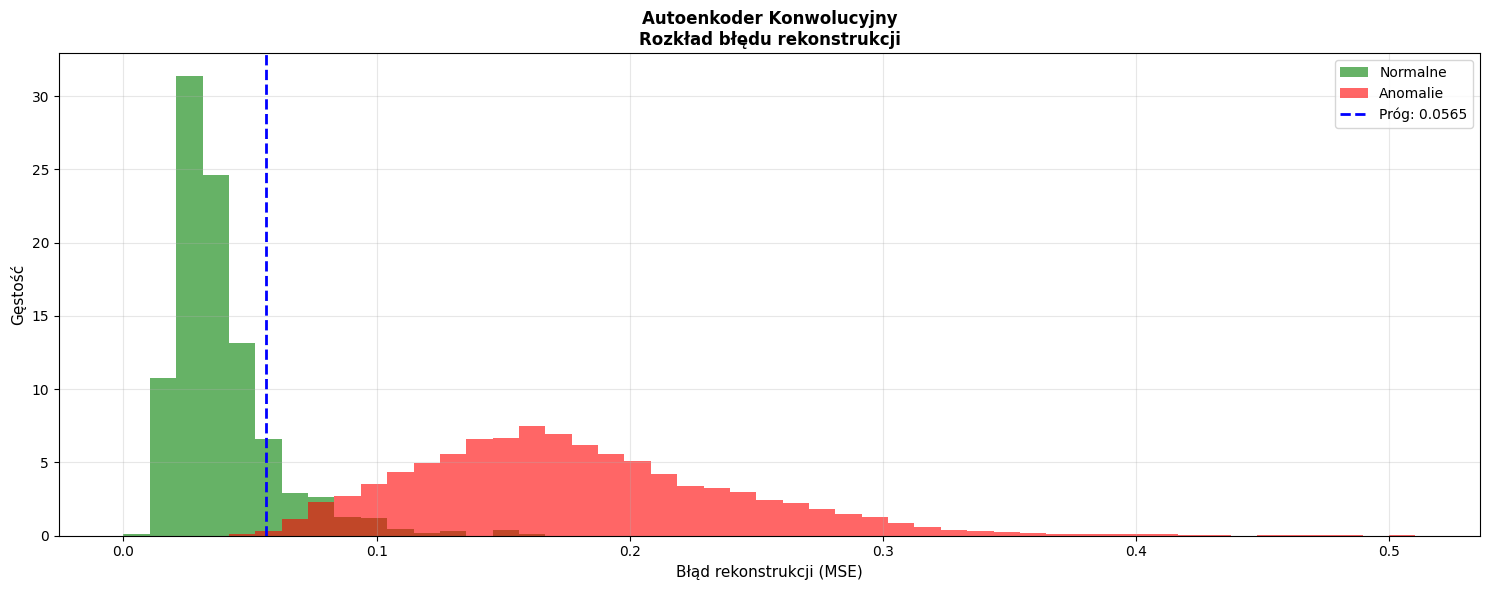

In [ ]:
# AUTOENKODER KONWOLUCYJNY
conv_ae = ConvAutoencoder()
conv_ae = train_autoencoder(conv_ae, train_loader, EPOCHS, LEARNING_RATE * 3, "Autoenkoder Konwolucyjny")

# Oblicz błędy rekonstrukcji
normal_errors_conv = calculate_reconstruction_error(conv_ae, test_normal_loader)
anomaly_errors_conv = calculate_reconstruction_error(conv_ae, test_anomaly_loader)

# Wyznacz próg 
threshold_conv = determine_threshold(normal_errors_conv, percentile=87)

# Ewaluacja
roc_auc, fpr, tpr, accuracy = evaluate_model(normal_errors_conv, anomaly_errors_conv, 
                                    threshold_conv, "Autoenkoder Konwolucyjny")
results["Autoenkoder Konwolucyjny"] = (roc_auc, fpr, tpr, accuracy)

# Wizualizacje
visualize_reconstructions(conv_ae, test_anomaly_loader, n_samples=5, 
                        model_name="Autoenkoder Konwolucyjny")
plot_error_distribution(normal_errors_conv, anomaly_errors_conv, 
                        threshold_conv, "Autoenkoder Konwolucyjny")

Dla autoenkodera konwolucyjnego natomiast mamy sytuację, gdzie w zależności od wielkości bottlenecka, mamy albo bardzo dobrze zrekonstruowane cyfry gdy bottleneck jest spory (jak jest większy to może zapamiętac więcej patternów) ale wtedy traci właściwości klasyfikacji między cyfrą normalną a anomalią. W naszym przypadku sieć tworzy mały bottleneck, który sprawia że tak jak w autoenkoderze liniowym, kształty przypominają 0 ale mają jakieś zalążki oryginalnych cyfr, natomiast klasyfikacja anomali stoi na bardzo wysokim poziomie.

Dodamy nowy model autoenkodera konwolucyjnego, aby potwierdzić to stwierdzenie, używając teraz większego bottlenecka


Trenowanie: Autoenkoder Konwolucyjny2
Epoch [5/30], Loss: 0.022133
Epoch [10/30], Loss: 0.017904
Epoch [15/30], Loss: 0.015803
Epoch [20/30], Loss: 0.014689
Epoch [25/30], Loss: 0.014157
Epoch [30/30], Loss: 0.013429

Wyniki: Autoenkoder Konwolucyjny2
Błąd rekonstrukcji - Normalne:
  Średnia: 0.012738
  Mediana: 0.011678
  Std: 0.005150

Błąd rekonstrukcji - Anomalie:
  Średnia: 0.017275
  Mediana: 0.016205
  Std: 0.008268

Próg anomalii: 0.017374

Detekcja:
  Poprawnie sklasyfikowane normalne: 852/980 (86.94%)
  Poprawnie sklasyfikowane anomalie: 3964/9020 (43.95%)
  Dokładność ogólna: 48.16%
  ROC AUC: 0.6853


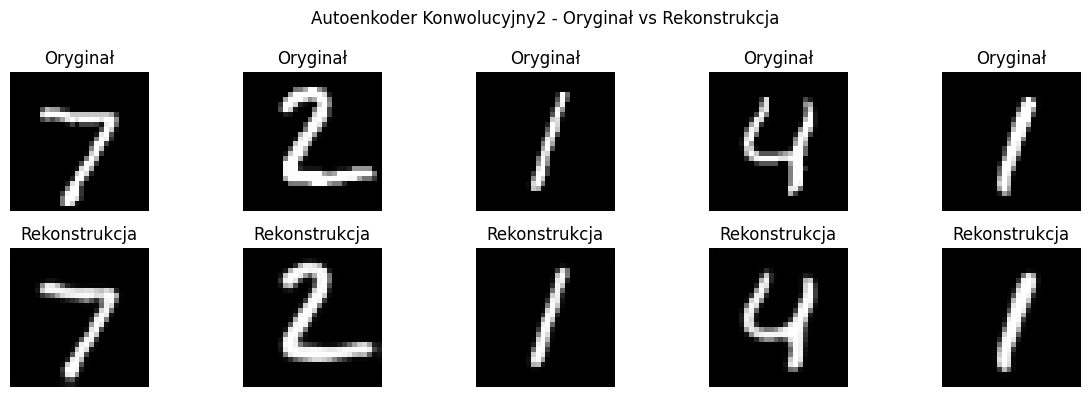

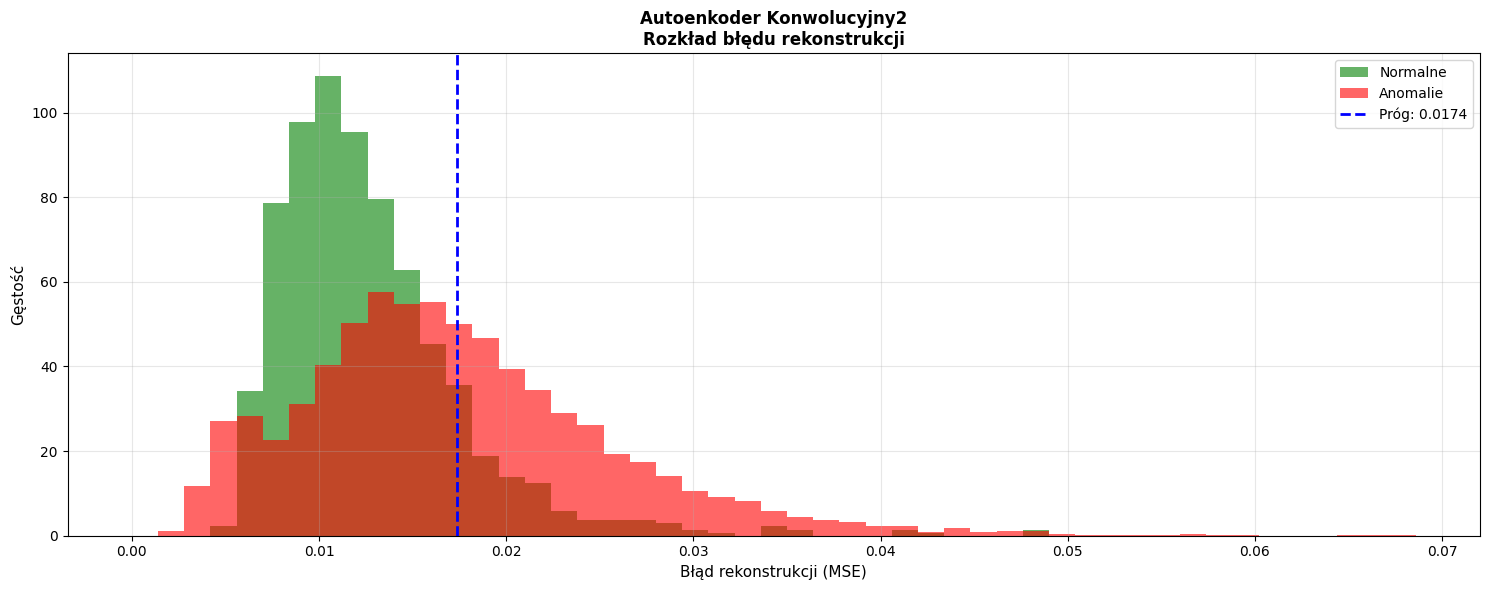

In [64]:
class ConvAutoencoder2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2, self).__init__()
        # Encoder - większy bottleneck dla lepszej rekonstrukcji
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Dropout2d(0.2),  # Dropout dla regularyzacji
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 14x14 -> 7x7
            nn.Dropout2d(0.2),
            
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7, zmniejszona pojemność!
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        # Decoder - symetryczna struktura z upsampling
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),  # Dopasowane do 16 kanałów
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),  # 7x7 -> 14x14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),  # 14x14 -> 28x28
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Sigmoid dla lepszej rekonstrukcji
        )
    
    def forward(self, x):
        # Normalizacja wejścia z [-1, 1] do [0, 1]
        x_normalized = (x + 1) / 2
        encoded = self.encoder(x_normalized)
        decoded = self.decoder(encoded)
        # Powrót do zakresu [-1, 1]
        decoded = decoded * 2 - 1
        return decoded

conv_ae = ConvAutoencoder2()
conv_ae = train_autoencoder(conv_ae, train_loader, EPOCHS, LEARNING_RATE * 3, "Autoenkoder Konwolucyjny2")
normal_errors_conv = calculate_reconstruction_error(conv_ae, test_normal_loader)
anomaly_errors_conv = calculate_reconstruction_error(conv_ae, test_anomaly_loader)
threshold_conv = determine_threshold(normal_errors_conv, percentile=87)
roc_auc, fpr, tpr, accuracy = evaluate_model(normal_errors_conv, anomaly_errors_conv, 
                                    threshold_conv, "Autoenkoder Konwolucyjny2")
results["Autoenkoder Konwolucyjny2"] = (roc_auc, fpr, tpr, accuracy)

visualize_reconstructions(conv_ae, test_anomaly_loader, n_samples=5, 
                        model_name="Autoenkoder Konwolucyjny2")
plot_error_distribution(normal_errors_conv, anomaly_errors_conv, 
                        threshold_conv, "Autoenkoder Konwolucyjny2")

Tak jak mówiłem, tutaj rekonstrukcja jest o wiele lepsza, ale model sklasyfikował poprawnie zaledwie 39% anomalii. Rozkład błędu rekonstrukcji pokazuje, że model nauczył się nie tylko zer ale wszystkich cyfr, dlatego ciężko odseparować anomalie od zera

In [57]:
# CNN    
cnn = CNN()
cnn = train_cnn(cnn, train_normal, test_normal_loader, test_anomaly_loader, 
                EPOCHS, LEARNING_RATE)

# Oblicz wyniki
normal_scores_cnn = calculate_cnn_scores(cnn, test_normal_loader)
anomaly_scores_cnn = calculate_cnn_scores(cnn, test_anomaly_loader)

# Ewaluacja
roc_auc, fpr, tpr, accuracy = evaluate_cnn(normal_scores_cnn, anomaly_scores_cnn, "CNN")
results["CNN"] = (roc_auc, fpr, tpr, accuracy)


Trenowanie: CNN
Dane treningowe: 5923 normalnych + 2961 anomalii
Epoch [5/30], Loss: 0.007279, Acc Normal: 99.90%, Acc Anomaly: 99.37%
Epoch [10/30], Loss: 0.001558, Acc Normal: 99.69%, Acc Anomaly: 99.61%
Epoch [15/30], Loss: 0.005299, Acc Normal: 99.69%, Acc Anomaly: 99.78%
Epoch [20/30], Loss: 0.000036, Acc Normal: 99.69%, Acc Anomaly: 99.66%
Epoch [25/30], Loss: 0.000009, Acc Normal: 99.69%, Acc Anomaly: 99.63%
Epoch [30/30], Loss: 0.000005, Acc Normal: 99.69%, Acc Anomaly: 99.63%

Wyniki: CNN
Wyniki - Normalne:
  Średnia: 0.997081
  Mediana: 1.000000
  Std: 0.052352

Wyniki - Anomalie:
  Średnia: 0.003671
  Mediana: 0.000000
  Std: 0.054184

Próg: 0.500000

Detekcja:
  Poprawnie sklasyfikowane normalne: 977/980 (99.69%)
  Poprawnie sklasyfikowane anomalie: 8987/9020 (99.63%)
  Dokładność ogólna: 99.64%
  ROC AUC: 0.9999


CNN zgodnie z oczekiwaniami bardzo dobrze klasyfikuje cyfry. Rozpoznając odpowiednie kształty

## Porównanie modeli


Wyniki: CNN
Wyniki - Normalne:
  Średnia: 0.997081
  Mediana: 1.000000
  Std: 0.052352

Wyniki - Anomalie:
  Średnia: 0.003671
  Mediana: 0.000000
  Std: 0.054184

Próg: 0.500000

Detekcja:
  Poprawnie sklasyfikowane normalne: 977/980 (99.69%)
  Poprawnie sklasyfikowane anomalie: 8987/9020 (99.63%)
  Dokładność ogólna: 99.64%
  ROC AUC: 0.9999

ROC AUC dla wszystkich modeli:
  Autoenkoder Liniowy: 0.9956
  Autoenkoder Konwolucyjny: 0.9934
  CNN: 0.9999
  Autoenkoder Konwolucyjny2: 0.6853

Accuracy dla wszystkich modeli:
  Autoenkoder Liniowy: 98.84%
  Autoenkoder Konwolucyjny: 98.50%
  CNN: 99.64%
  Autoenkoder Konwolucyjny2: 48.16%


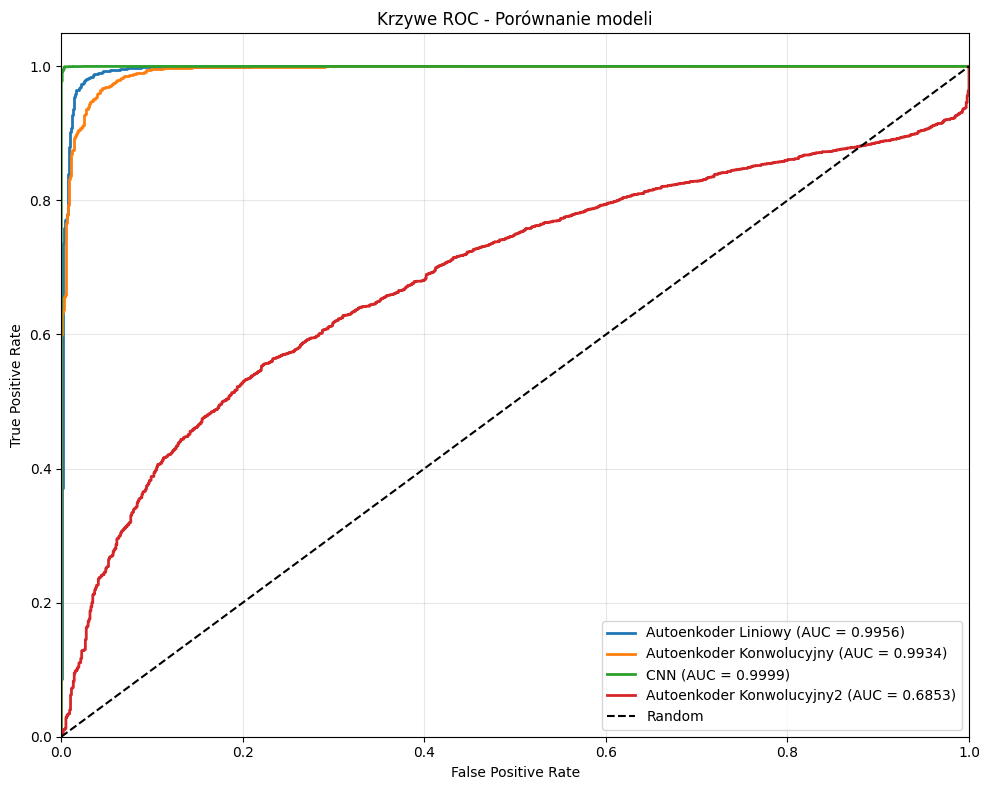

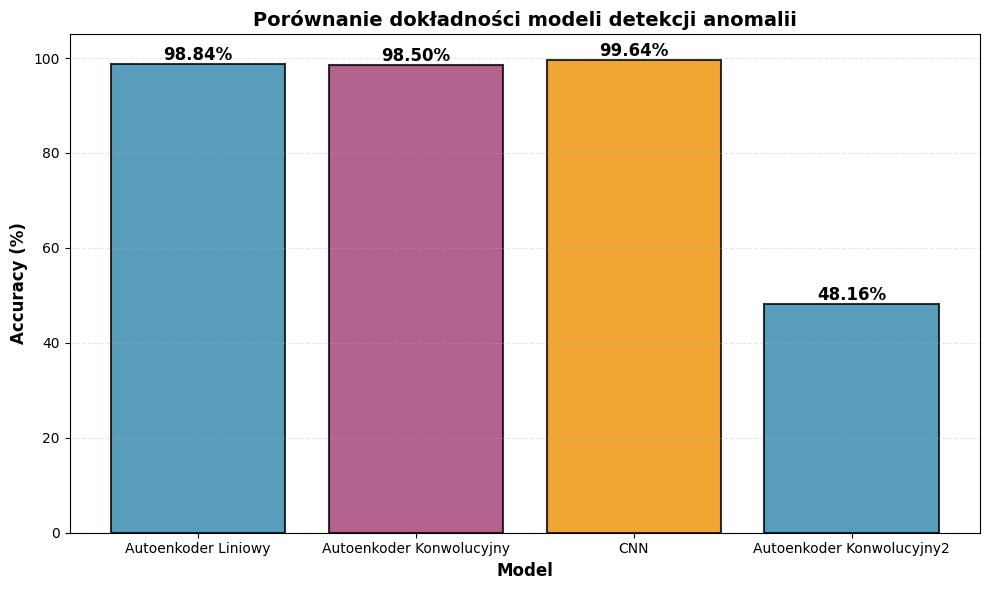

In [69]:
normal_scores_cnn = calculate_cnn_scores(cnn, test_normal_loader)
anomaly_scores_cnn = calculate_cnn_scores(cnn, test_anomaly_loader)

roc_auc, fpr, tpr, accuracy = evaluate_cnn(normal_scores_cnn, anomaly_scores_cnn, "CNN")
results["CNN"] = (roc_auc, fpr, tpr, accuracy)

# Porównanie wszystkich modeli
print("\nROC AUC dla wszystkich modeli:")
for model_name, (roc_auc, _, _, _) in results.items():
    print(f"  {model_name}: {roc_auc:.4f}")

print("\nAccuracy dla wszystkich modeli:")
for model_name, (_, _, _, accuracy) in results.items():
    print(f"  {model_name}: {accuracy:.2f}%")

all_errors = {
    "Autoenkoder Liniowy": {
        "normal": normal_errors_linear,
        "anomaly": anomaly_errors_linear
    },
    "Autoenkoder Konwolucyjny": {
        "normal": normal_errors_conv,
        "anomaly": anomaly_errors_conv
    }
}

plot_roc_curves(results)
plot_accuracy_comparison(results)


Te wykresy w zasadzie potwierdzają to co już wcześniej zostało opisane